# Explore UMI Cutoffs

In [2]:
import os
import sys
from pathlib import Path
from collections import namedtuple
from textwrap import dedent

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs
from larval_gonad.config import memory
from larval_gonad.cell_selection import cellranger_counts, barcode_rank_plot_with_cells, filter_gene_counts_by_barcode

# Setup notebook
nbconfig = Nb.setup_notebook('2018-03-21_explore_umi')

last updated: 2018-03-26 
Git hash: 0e78dce8413b08a6852759bfce844a9f30437ed8


In [3]:
mpl.style.use(['common', 'talk'])

In [4]:
t1 = 'testis1'
names = {
    'testis1': 'Testis Rep 1',
    'testis2': 'Testis Rep 2',
    'testis3': 'Testis Rep 3',
}
runs = ['testis1', 'testis2', 'testis3']

In [5]:
umis = {}
counts = {}
for run in runs:
    umis[run] = pd.read_parquet(f'../output/{run}/larval_umi.parquet')
    counts[run] = cellranger_counts(f'../output/{run}/outs/raw_gene_bc_matrices_h5.h5')

The cell ranger cell detection algorithm did not return the expected number of cells. 
This algorithm does not perform well when there are large differences in RNA content among cell populations. 
In our testis data we expect to see cell types with large differences in RNA content. 
To decide on a better starting point, here I explore the number of unique molecule (UMI) per cell as a way to 
establish which cell barcodes correspond to a cell and which barcodes correspond to debris or background. 

In [6]:
u1 = umis[runs[0]].umi_count.sum()
u2 = umis[runs[1]].umi_count.sum()
u3 = umis[runs[2]].umi_count.sum()

c1 = len(counts[runs[0]].barcodes)
c2 = len(counts[runs[1]].barcodes)
c3 = len(counts[runs[2]].barcodes)

HTML(f"""
<table class="table table-striped">
<tr>
<td></td><th>Total Number of UMI</th><th>Total Number of Cell Barcodes</th>
</tr>
<tr>
<th>Testis 1</th><td>{u1:,}</td><td>{c1:,}</td>
</tr>
<tr>
<th>Testis 2</th><td>{u2:,}</td><td>{c2:,}</td>
</tr>
<tr>
<th>Testis 3</th><td>{u3:,}</td><td>{c3:,}</td>
</tr>
</table>
""")

,Total Number of UMI,Total Number of Cell Barcodes
Testis 1,"55,509,962","737,280"
Testis 2,"124,870,271","737,280"
Testis 3,"113,490,916","737,280"


Below I look at 4 different UMI cutoffs 10,000|5,000|2,000|1,000. 
A UMI cutoff of 10,000 returns a lower than expected number of cells for replicates 1 and 3.
While a UMI cutoff of 1,000 returns more cells for replicates 1 and 2 than were loaded on the machine.
The middle two cutoffs 5,000|2,000 both return a reasonble number of cells, but cell number is a little lower than expected with the 5,000 cutoff.
However, the median per cell gene expression is perhaps a little with the 2,000 cutoff.

Replicate 1 behaves slightly differently than the other two replciates, which is perhaps due to having more than half of the unique molecules captured as replicates 2 and 3.
In spite of this, replicate 1 still has ~0.90 spearman's r showing consitency, but not as good as replicates 2 and 3 which had 0.99.

In [12]:
def _plot_barcode(cutoff, axes):
    axes[1].text(0.5, 1.1, f"UMI Cutoff: {cutoff:,}", transform=axes[1].transAxes, ha='center', size=14)
    
    for i, run in enumerate(runs):
        ax = axes[i]
        bg = umis[run]
        sel = umis[run].query(f'umi_count >= {cutoff}')
        barcode_rank_plot_with_cells(bg, sel, names[run], ax=ax)

        df = filter_gene_counts_by_barcode(sel.index, counts[run])
        num_genes = (df.sum(axis=1) > 0).sum()
        genes_per_cell = (df > 0).sum().median()
        ax.text(
            1, 
            100, 
            dedent(
                f""" 
                Number of Cells: {len(sel):,}
                Expressed Genes: {num_genes:,}
                Median Genes Per cell: {genes_per_cell:,.0f}
                """
            )
       )

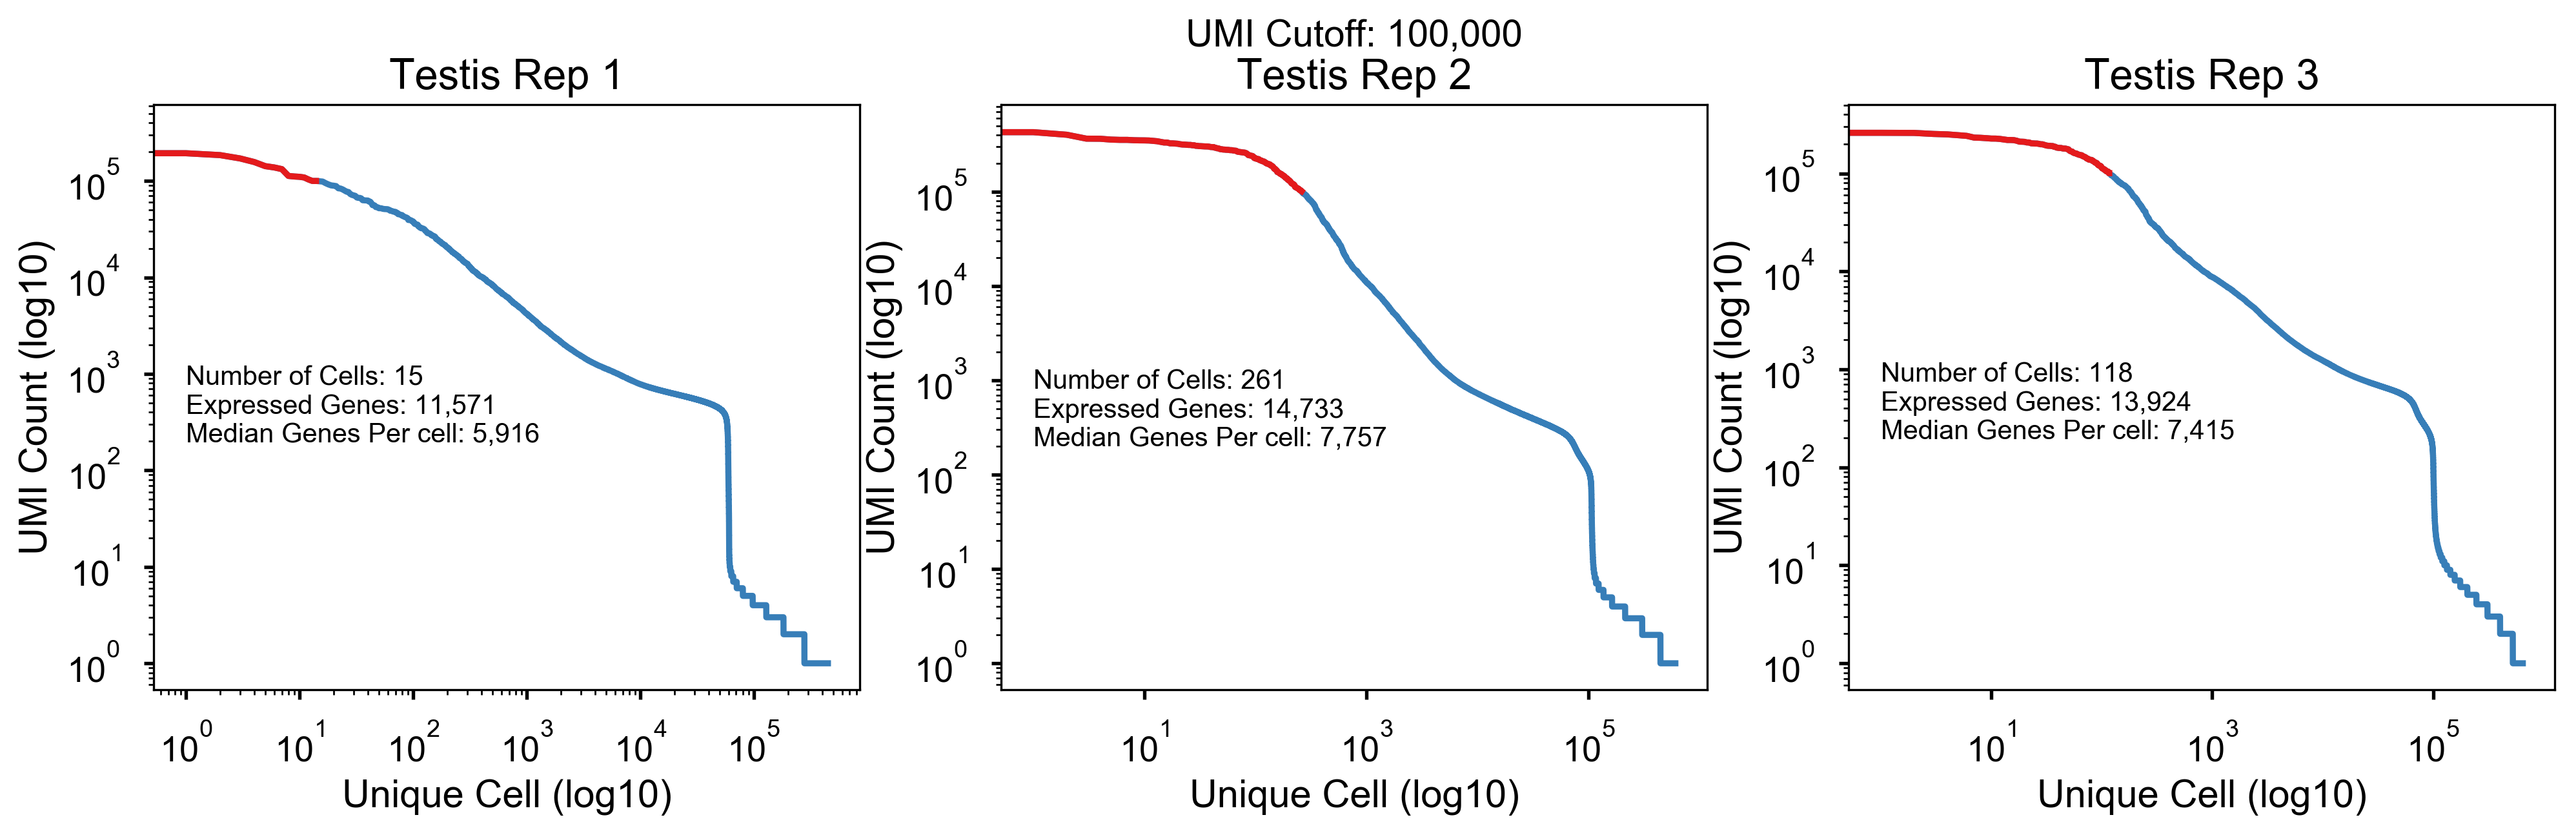

In [20]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(1/4))
_plot_barcode(100000, axes)

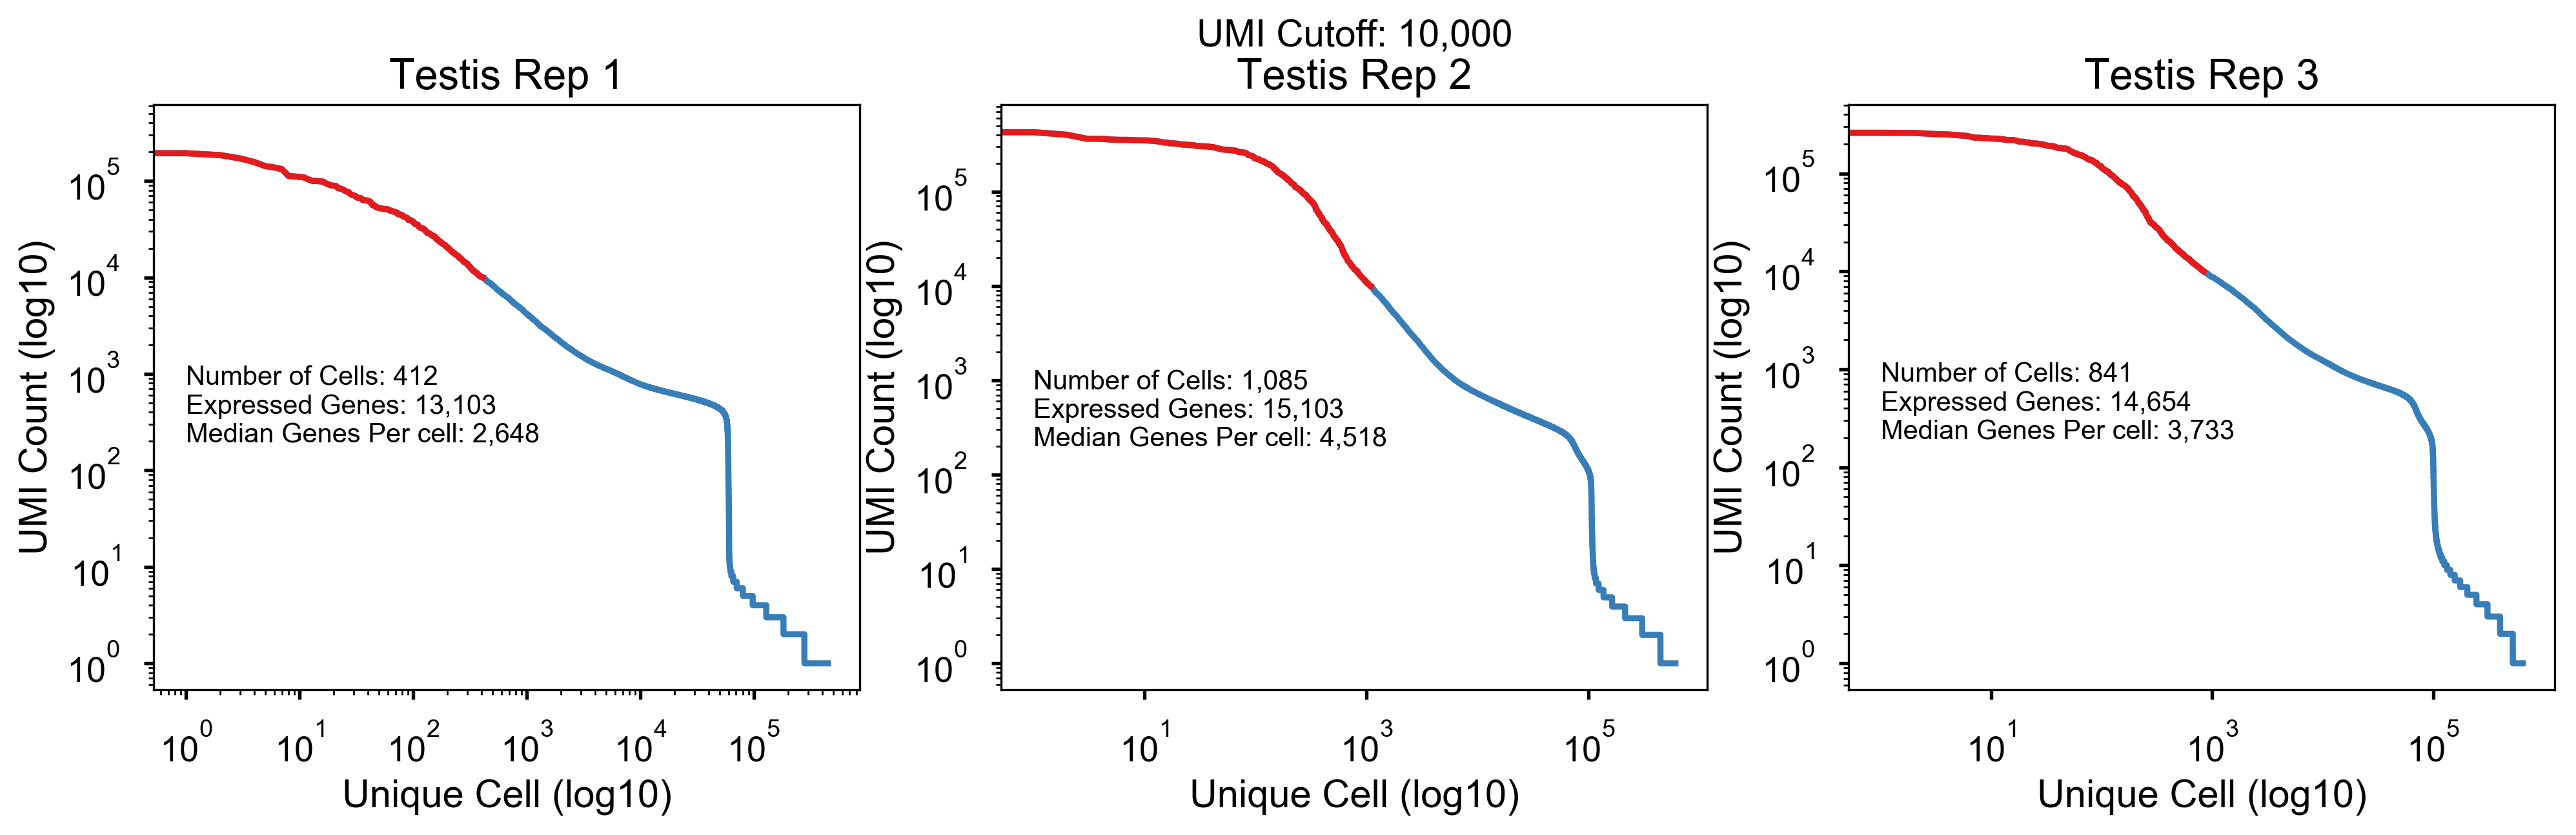

In [16]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(1/4))
_plot_barcode(10000, axes)

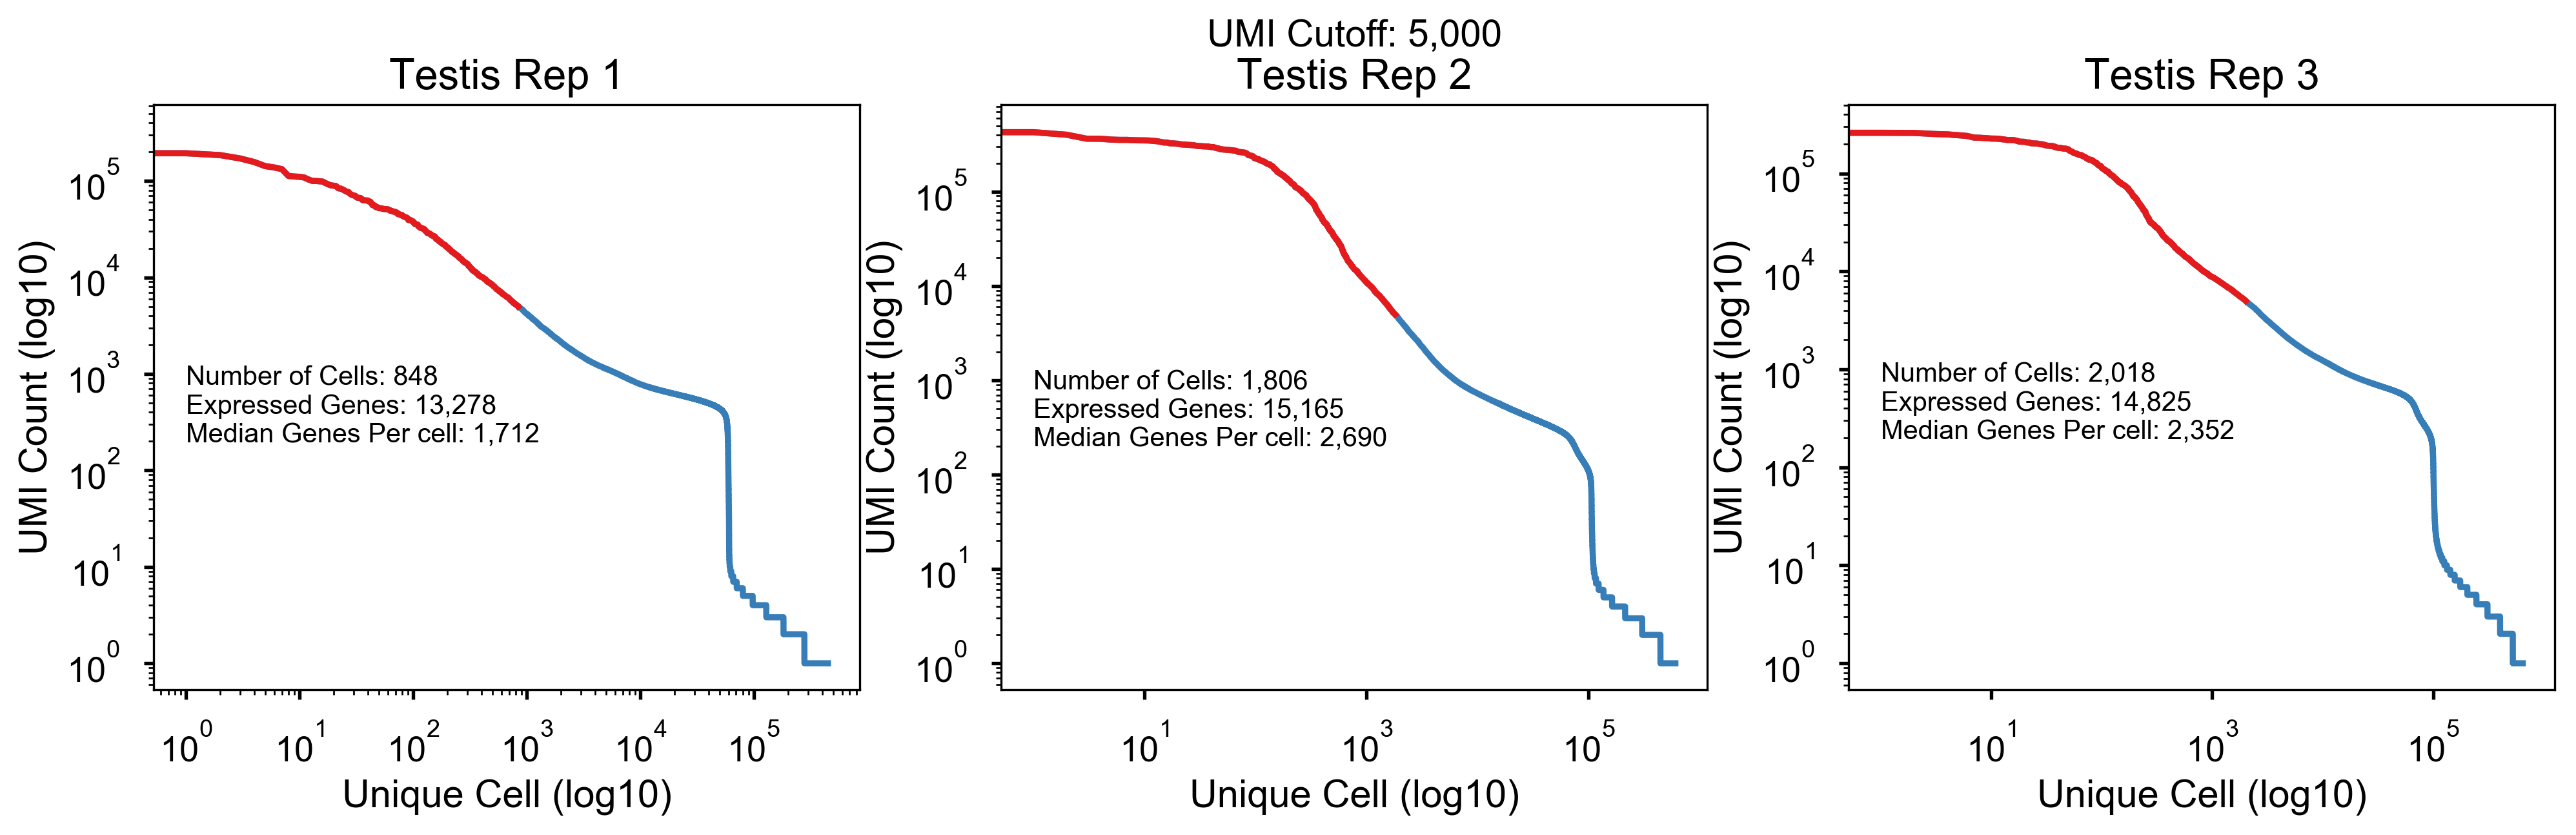

In [17]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(1/4))
_plot_barcode(5000, axes)

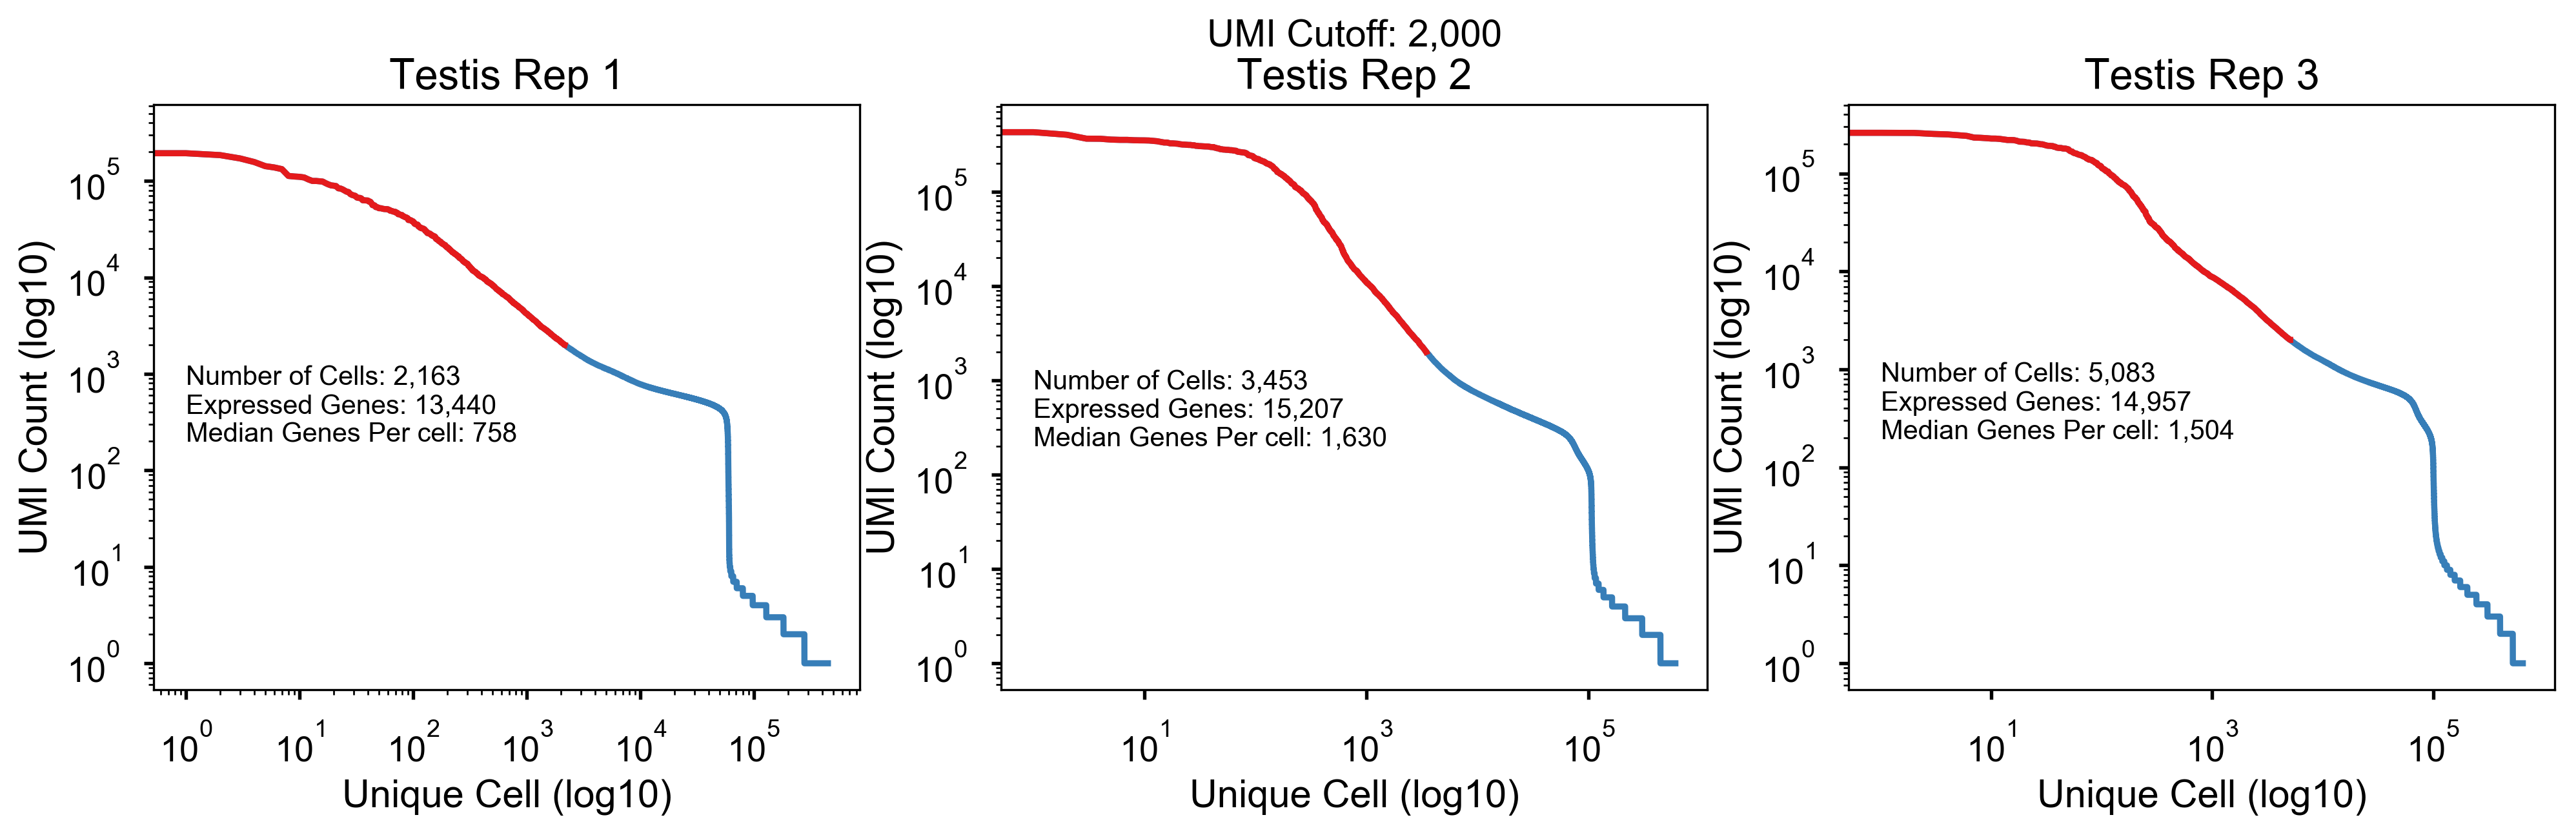

In [18]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(1/4))
_plot_barcode(2000, axes)

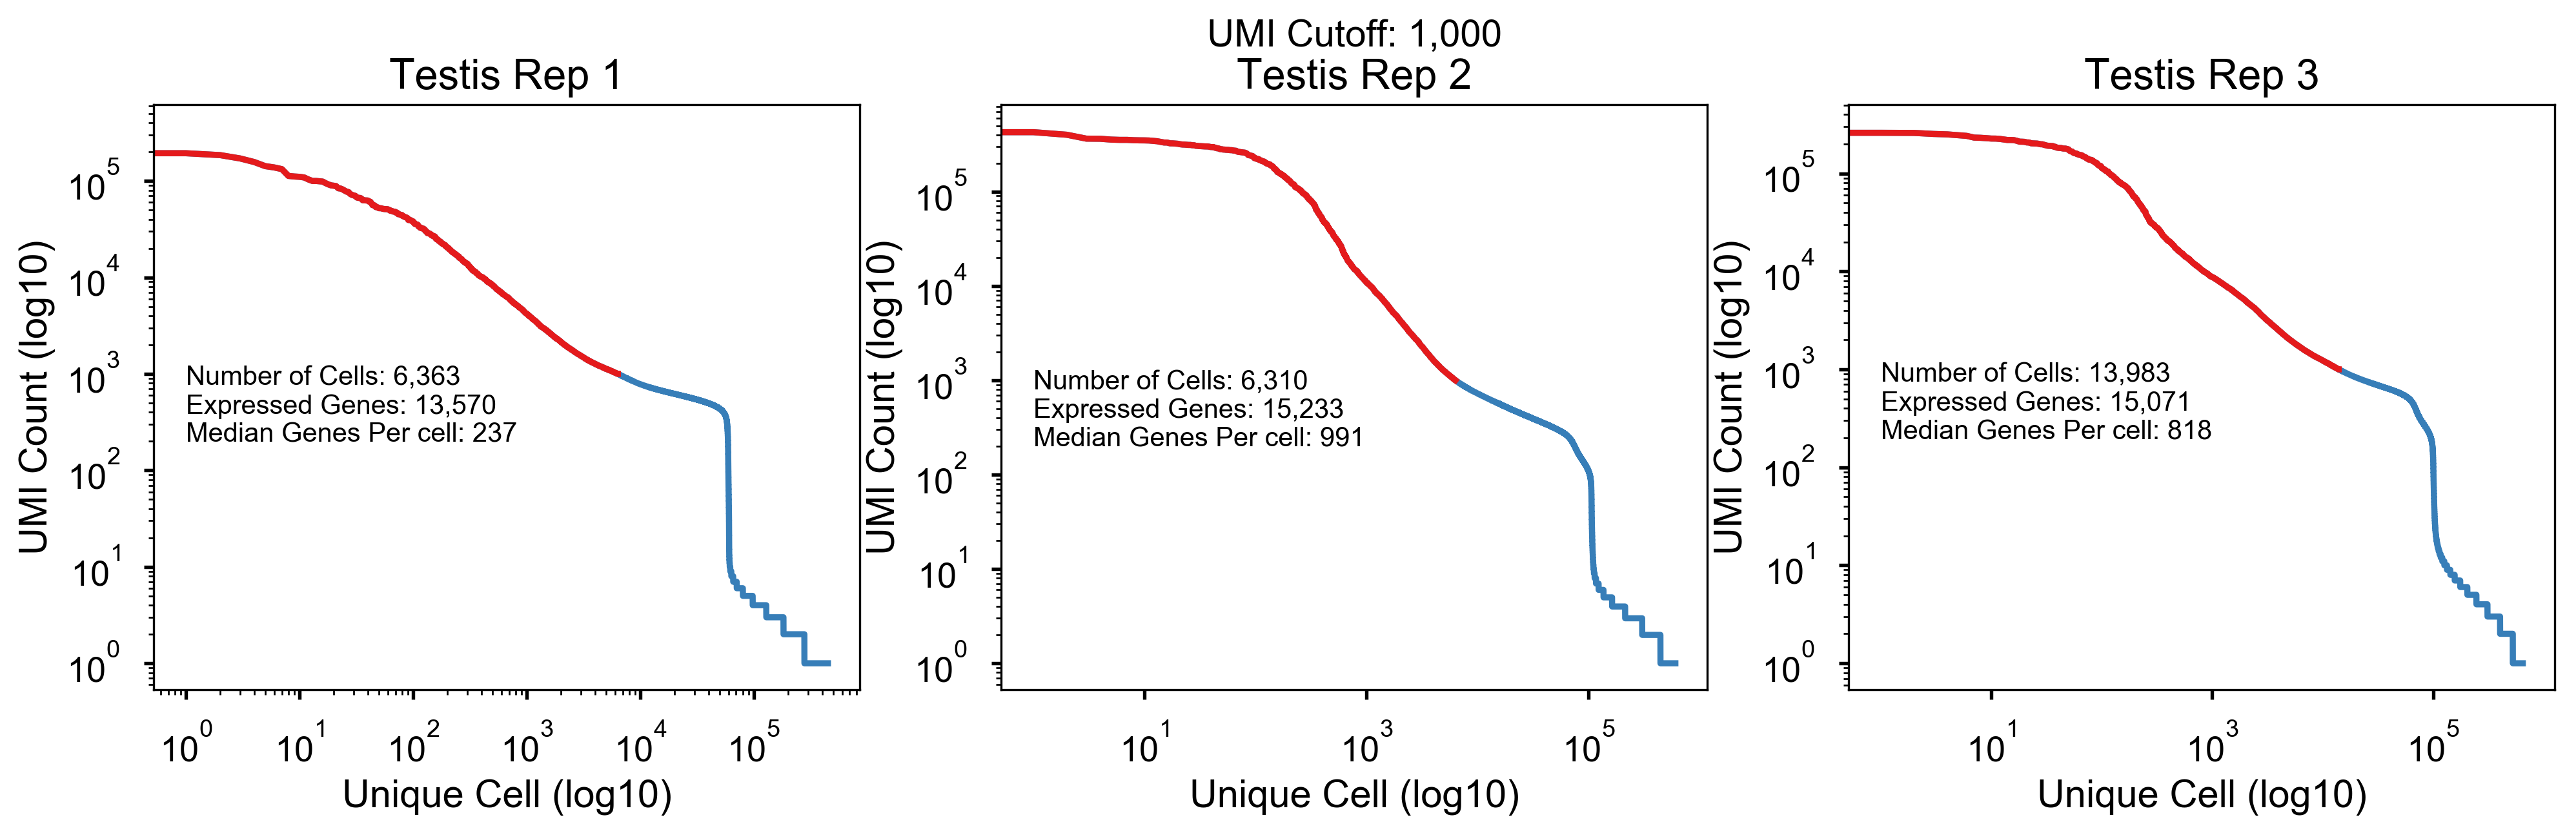

In [19]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(1/4))
_plot_barcode(1000, axes)

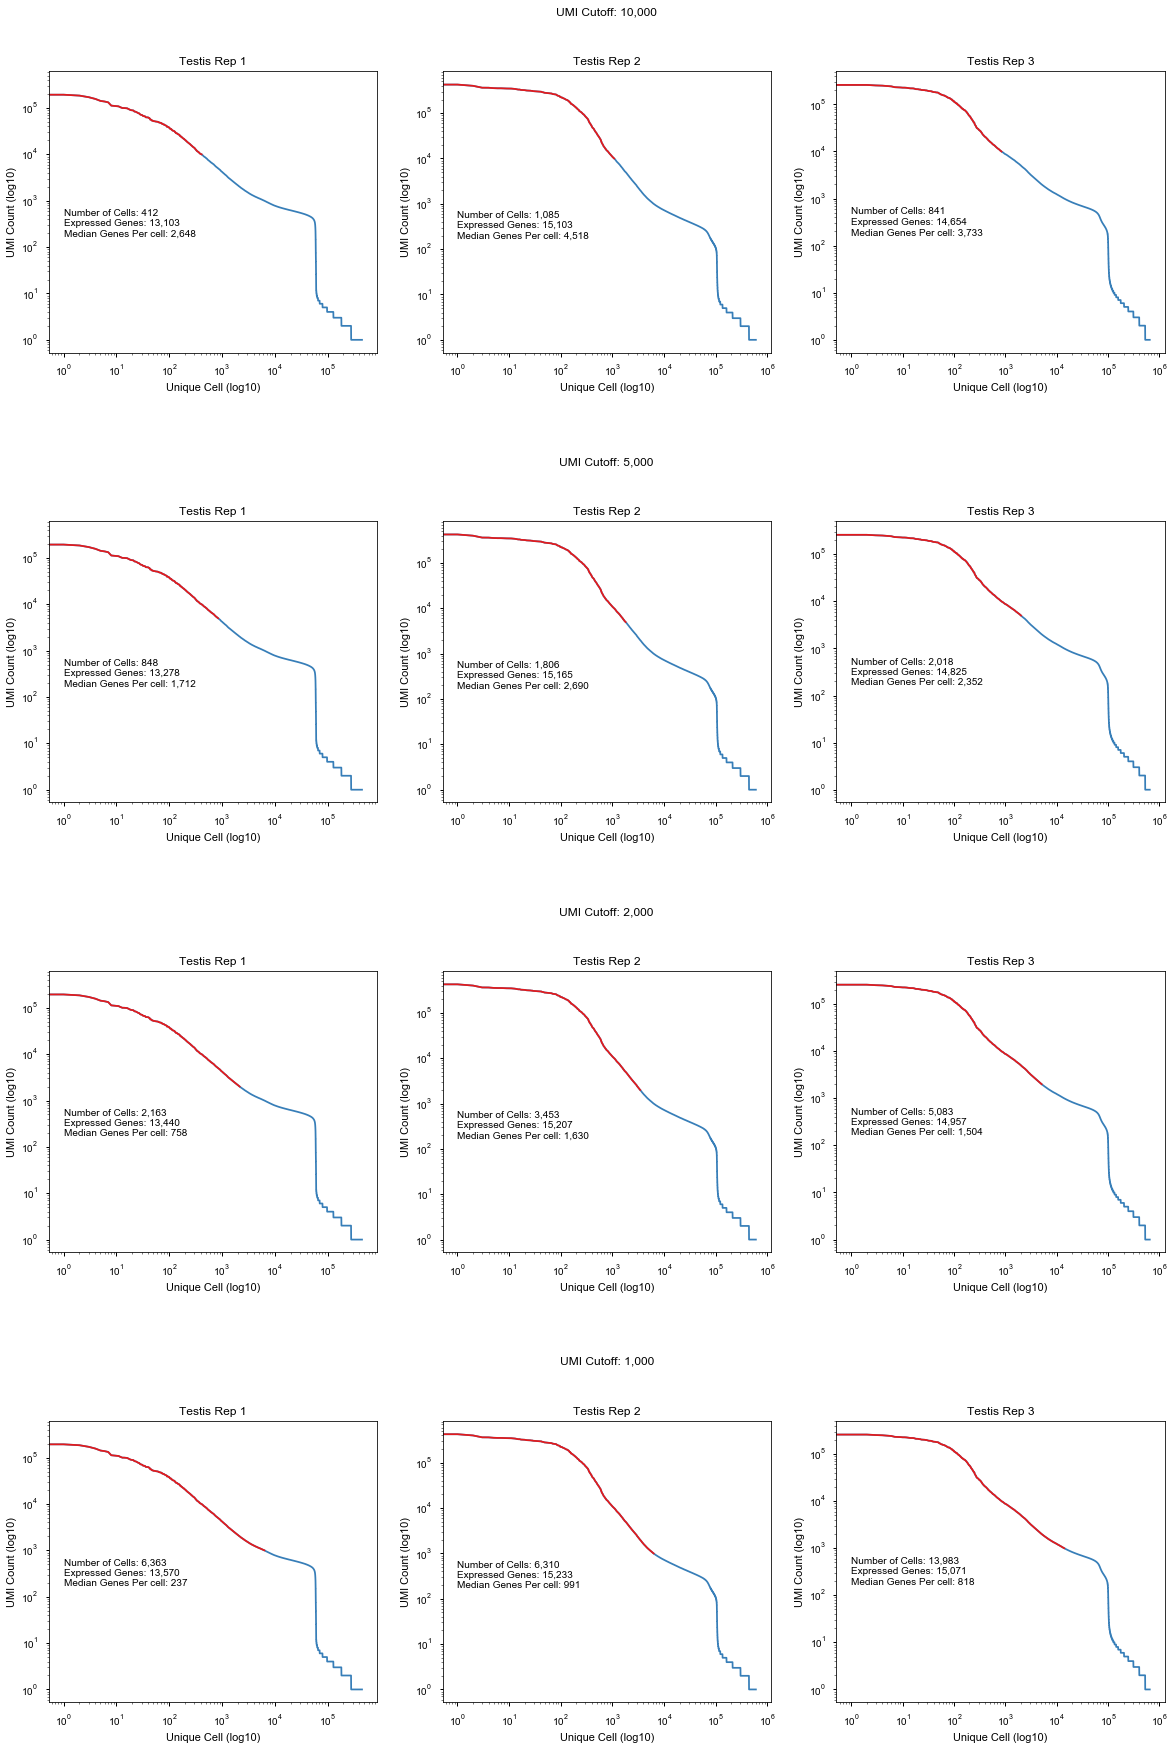

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(20, 30))
plt.subplots_adjust(hspace=.6)

_plot_barcode(10000, axes[0, :])
_plot_barcode(5000, axes[1, :])
_plot_barcode(2000, axes[2, :])
_plot_barcode(1000, axes[3, :])

In [7]:
def _plot_scatter(cutoff, axes):
    axes[1].text(0.5, 1.2, f"UMI Cutoff: {cutoff:,}", transform=axes[1].transAxes, ha='center', size=12)
    
    dfs = {}
    for run in runs:
        bcs = umis[run].query(f'umi_count >= {cutoff}').index
        dfs[run] = np.log(filter_gene_counts_by_barcode(bcs, counts[run]).sum(axis=1) + 1)
        
    idx1 = runs[0]
    idx2 = runs[1]
    ax = axes[0]
    name1 = names[idx1]
    name2 = names[idx2]
    r = spearmanr(dfs[idx1], dfs[idx2]).correlation
    ax.scatter(dfs[idx1], dfs[idx2])
    ax.set_title(f'{name1}-{name2}')
    ax.text(.6, .1, f"Spearman r: {r:0.4f}", transform=ax.transAxes)
    ax.set_xlabel(f'{name1} Log Expression')
    ax.set_ylabel(f'{name2} Log Expression')
    
    idx1 = runs[0]
    idx2 = runs[2]
    ax = axes[1]
    name1 = names[idx1]
    name2 = names[idx2]
    r = spearmanr(dfs[idx1], dfs[idx2]).correlation
    ax.scatter(dfs[idx1], dfs[idx2])
    ax.set_title(f'{name1}-{name2}')
    ax.text(.6, .1, f"Spearman r: {r:0.4f}", transform=ax.transAxes)
    ax.set_xlabel(f'{name1} Log Expression')
    ax.set_ylabel(f'{name2} Log Expression')
    
    idx1 = runs[1]
    idx2 = runs[2]
    ax = axes[2]
    name1 = names[idx1]
    name2 = names[idx2]
    r = spearmanr(dfs[idx1], dfs[idx2]).correlation
    ax.scatter(dfs[idx1], dfs[idx2])
    ax.set_title(f'{name1}-{name2}')
    ax.text(.6, .1, f"Spearman r: {r:0.4f}", transform=ax.transAxes)
    ax.set_xlabel(f'{name1} Log Expression')
    ax.set_ylabel(f'{name2} Log Expression')

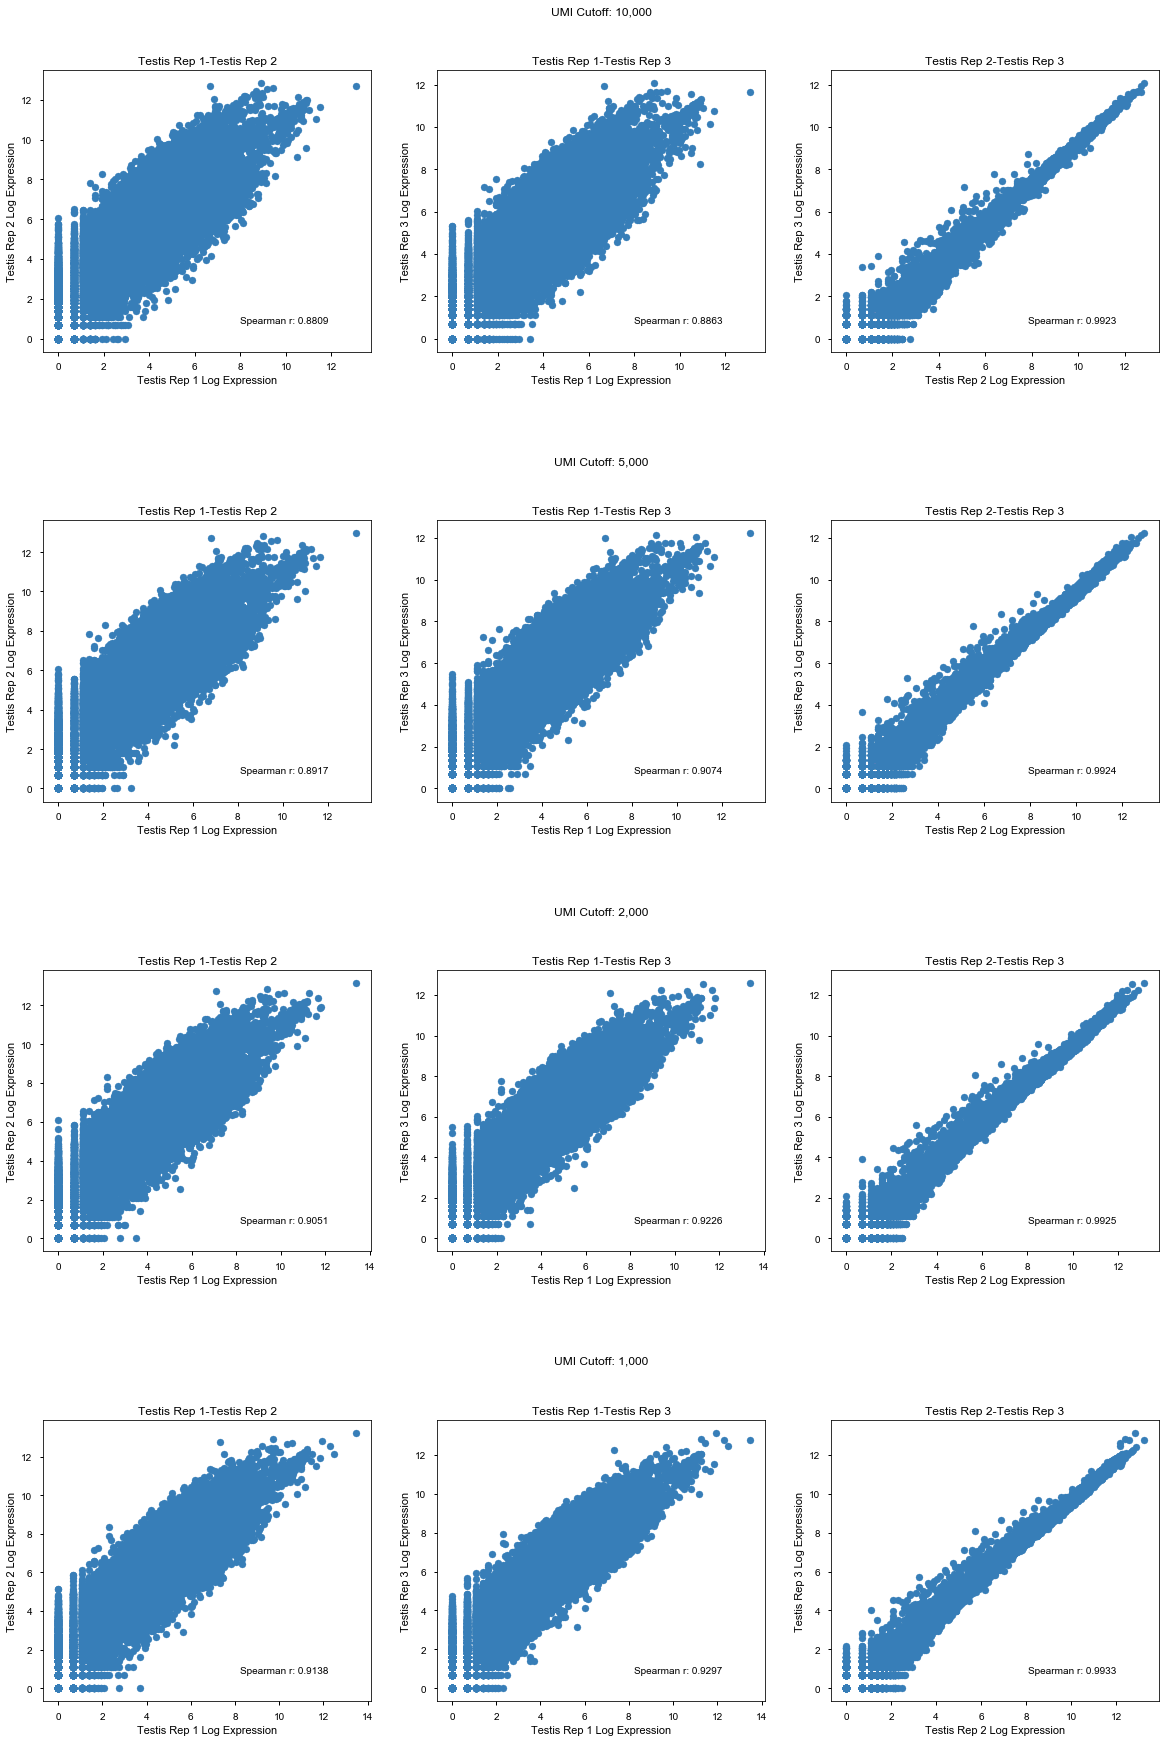

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(20, 30))
plt.subplots_adjust(hspace=.6)

_plot_scatter(10000, axes[0, :])
_plot_scatter(5000, axes[1, :])
_plot_scatter(2000, axes[2, :])
_plot_scatter(1000, axes[3, :])

## Export Datasets

In [10]:
def dump(cutoff):
    for run in runs:
        oname = nbconfig.table_name(f'{run}_{cutoff}.tsv')
        bcs = umis[run].query(f'umi_count >= {cutoff}').index
        df = filter_gene_counts_by_barcode(bcs, counts[run])
        df.to_csv(oname, sep='\t')

In [ ]:
dump(1000)
dump(2000)
dump(5000)
dump(10000)